# Multiclass Task Notebook
#### Contains Code for Binary task SVM Model creation, training, validation(hyperparameter tuning and cross validation) and testing on sample test set<br/> The multiclass targets are arranged as<br/>no_tumor = 0<br/>glioma_tumor = 1<br/>meningioma_tumor = 2<br/>pituitary_tumor = 3<br/>Respectively
##### Produces 2 plots for report, confusion matrices for tuned and untuned svm predictions, saving model and plot code has been commented out to prevent accidental overwriting

In [15]:
# Import required libraries
import numpy as np
import pandas as pd
import pickle as pkl
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.decomposition import PCA

#tqdm is for progress bar functionality in code, must be installed for code to function
from tqdm import tqdm

#Importing libraries used for SVM classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

#Importing functions notebook containing functions created to streamline code
from ipynb.fs.full.functions import load_dataset, dataset_PCA, Tuned_SVM_train, SVM_predictions

ERROR! Session/line number was not unique in database. History logging moved to new session 378


# 1. Loading Dataset and doing final preprocessing
#### We Load the preprocessed data and carry out PCA on the image array here for multi-classification training and test data. <br/> Initial data preprocessing code will be very similar to Binary Task SVM as the only difference is the use of the multiclass label file instead of binary.
## 1.1 Loading Datasets

In [2]:
#Calls load_dataset function from "functions.ipynb" which loads the X data and Y label datasets for Multiclass task from the inputted file paths
#It prints the loaded array shapes to verify it has completed properly
X, Y = load_dataset('.\dataset\Image_DF_Flat.pkl', './dataset/Y_Multiclass_label.pkl')

Datasets successfully loaded with shapes:
Y Shape:
(3000,)
X Shape:
(3000, 784)


##### We can do PCA for the images but must be done separately for binary and multiclass task as the data must be split first<br/> This is because we must do PCA on the training data only (fit and transform it) and then only use the transform on the test data to prevent bias<br/> We select 400 components as it provides around 96% explained variance as shown previously.

## 1.2 Splitting data in to training and testing sets

In [3]:
# Split the data into training and testing(70% training and 30% testing data)
# Setting random_state to 42 keeps the same random generator seed to be used.
# This maintains the split used across code executions so results obtained will be the same for other users
# The training set will be used for training and validation
# Validation in terms of using it to assess and tune the hyperparameter values using Grid Search as well as cross validation on the hyperparameter values
xTrain,xTest,yTrain,yTest=train_test_split(X, Y, train_size = 0.7, random_state = 42)

#To verify split data is the same 
#print(xTrain)

#Rescaling the dataframe as the pixel values range from 0 to 255
#We want it to be between 0 to 1 to let it pass through the NN and models
xTrain_Scaled = xTrain/255
xTest_Scaled = xTest/255

#### 1.2.1 Displaying label distribution<br/> We show the the number of samples in each class label 

In [4]:
#Number of Samples per class in training data
print("Training dataset number of samples per class:")
print(yTrain.value_counts())

#Number of Samples per class in test data
print("Test dataset number of samples per class:")
print(yTest.value_counts())

#This shows that there are four unique classes in the multi-class problem with a slight imbalance with 0 (no tumor) 
# having relatively fewer samples compared to the other 3 tumor type classes.

Training dataset number of samples per class:
1.0    603
2.0    591
3.0    586
0.0    320
Name: MRI_Multiclass_Label, dtype: int64
Test dataset number of samples per class:
2.0    264
1.0    257
3.0    245
0.0    134
Name: MRI_Multiclass_Label, dtype: int64


## 1.3 PCA

In [5]:
#Initialising PCA with 400 components determined in preprocessing notebook
#Calls the dataset_PCA function defined in "functions.ipynb" to carry out PCa
#Input arguements are number of components, xTrain data and xTest data
#We put in the scaled X train and test data
xTrain_PCA, xTest_transformed = dataset_PCA(400, xTrain_Scaled, xTest_Scaled)

#Function returns the resultant explained variance percentage when we use 400 components.
#Verified that explained variance using 400 components is ~96.499%

PCA conducted with 400 components.
The percentage of Explained Variance of the dataset from PCA is: 96.50347927486393


# 2. Model Building

## 2.1 SVM without tuning
### 2.1.1 Training<br/> We first train SVM without hyperparameter tuning to assess the performance of the model with the training and test data

In [6]:
#Training model using SVC without hyperparameter tuning
#SVC allows automatic scaling of weights to counter imbalanced datasets. This is done by setting class_weight to 'balanced'
#Default value for C is 1
#Default value for gamma is = 1 / (n_features * X.var())
multiclass_SVM_untuned = SVC(probability = True, class_weight= 'balanced')
multiclass_SVM_untuned.fit(xTrain_PCA, yTrain.values.ravel())

SVC(class_weight='balanced', probability=True)

### 2.1.2 Obtaining the Prediction results and performance<br/> Showing the confusion matrix and general assessment metrics using the classification report

In [7]:
#Calls SVM_predictions function from "functions.ipynb" to carry out the predictions using the untuned multiclass SVM model we made.
#It prints out the classification report of the predictions as well as the confusion matrix
#Returns the predictions
multiclass_SVM_untuned_pred = SVM_predictions(multiclass_SVM_untuned, xTest_transformed, yTest) 

The Results for SVM are:
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       134
         1.0       0.76      0.84      0.80       257
         2.0       0.83      0.69      0.75       264
         3.0       0.88      0.96      0.92       245

    accuracy                           0.82       900
   macro avg       0.82      0.82      0.82       900
weighted avg       0.82      0.82      0.82       900

The confusion matrix is:
[[107   8  10   9]
 [  7 217  26   7]
 [ 16  50 183  15]
 [  0   9   2 234]]


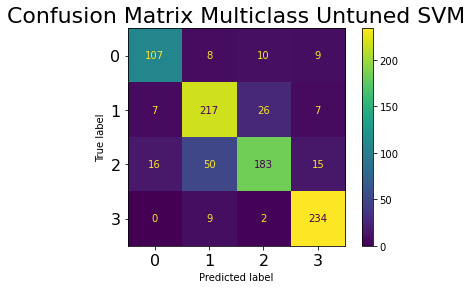

In [13]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(yTest, multiclass_SVM_untuned_pred))

cm_plot.plot()
#Labels for title and axis
plt.title('Confusion Matrix Multiclass Untuned SVM', fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#Saves plot to be used in the report COMMENTED OUT SO IT WONT OVERWRITE PLOTS FOR NOW
#plt.savefig('./Plots/CM_Multiclass_UntunedSVM.jpg', bbox_inches='tight')

## 2.2 SVM with validation

### 2.2.1 Training<br/> We now use SVM again but with validation, tuning of the hyperparameter values<br/> This is done using an exhaustive Gridsearch of the parameter values given. <br/> After model is trained, we obtain the best parameters found by the gridsearch

In [9]:
#Using SVM but this time with gridsearch to tune hyperparameter

#Define the parameter ranges
#We test various values of:
# C
# gamma
# Type of Kernel to use
# The values are arranged in logarithmic increments
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly']
}


In [10]:
#Calls Tuned_SVM_train from "functions.ipynb" to conduct training and tuning of SVM model using gridsearch
#Full details on the input arguements listed in the functions notebook

#Function prints the resultant best hyperparameters found and new details of the model
#Returns the tuned model
multiclass_SVM_Tuned = Tuned_SVM_train(param_grid, 5, xTrain_PCA, yTrain, True)

#est time = 11mins

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Tuned SVM Model successfully trained and tuned
The best hyperparameters found by gridsearch are:
{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
The new model created after hyperparameter tuning is:
SVC(C=100, class_weight='balanced', gamma=0.1, probability=True)


### 2.2.2 Obtaining the Prediction results and performance<br/> Showing the confusion matrix and general assessment metrics using the classification report

In [11]:
#Calls SVM_predictions function from "functions.ipynb"
#This time we are doing predictions with the tuned SVM model
multiclass_SVM_Tuned_pred = SVM_predictions(multiclass_SVM_Tuned , xTest_transformed, yTest)

#It prints out the classification report of the predictions as well as the confusion matrix
#Returns the predictions

The Results for SVM are:
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.81       134
         1.0       0.81      0.88      0.84       257
         2.0       0.82      0.80      0.81       264
         3.0       0.92      0.96      0.94       245

    accuracy                           0.86       900
   macro avg       0.87      0.84      0.85       900
weighted avg       0.86      0.86      0.86       900

The confusion matrix is:
[[ 98   5  22   9]
 [  1 225  25   6]
 [  8  39 212   5]
 [  0   8   1 236]]


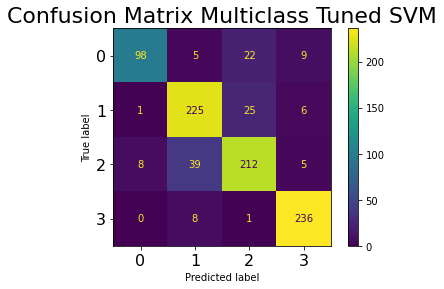

In [12]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(yTest, multiclass_SVM_Tuned_pred))

cm_plot.plot()
#Labels for title and axis
plt.title('Confusion Matrix Multiclass Tuned SVM', fontsize=22)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

#Saves plot to be used in the report COMMENTED OUT SO IT WONT OVERWRITE PLOTS FOR NOW
#plt.savefig('./Plots/CM_Multiclass_TunedSVM.jpg', bbox_inches='tight')

# 3. Comparing Models Area Under ROC curve metrics
#### We obtain the general AUC metric from tuned and untuned models using one vs one scheme.<br/> That is comparing each class pairwise and returning the weighted average AUC metric.

In [19]:
yTest_OneHot = to_categorical(yTest)
multiclass_SVM_untuned_pred_OH = to_categorical(multiclass_SVM_untuned_pred)
multiclass_SVM_Tuned_pred_OH = to_categorical(multiclass_SVM_Tuned_pred )

In [23]:
Untuned_AUC_weighted_ovo = roc_auc_score(yTest_OneHot, multiclass_SVM_untuned_pred_OH, average = 'macro', multi_class= 'ovo')
print("Untuned SVM macro average AUC metric: ", Untuned_AUC_weighted_ovo)
Tuned_AUC_weighted_ovo = roc_auc_score(yTest_OneHot, multiclass_SVM_Tuned_pred_OH, average = 'macro', multi_class= 'ovo')
print("Tuned SVM macro average AUC metric: ", Tuned_AUC_weighted_ovo)

Untuned SVM macro average AUC metric:  0.881230931232005
Tuned SVM macro average AUC metric:  0.8968123699958994


# 4. Saving Trained Models
### THIS SECTION HAS BEEN COMMENTED OUT CURRENTLY TO PREVENT OVERWRITING ORIGINAL MODEL, can uncomment to check if the saving process works however will overwrite the model weights used to obtain prediction results shown in report.

In [14]:
#Saving tuned and base SVM models

#save_path = "./Models/Multiclassification"
#Tuned_SVM_filename = 'Tuned_multiclass_SVM.sav'
#Base_SVM_filename = 'Untuned_multiclass_SVM.sav'

#Using Pickle to put them in files

#pkl.dump(multiclass_SVM_untuned , open(os.path.join(save_path, Base_SVM_filename), 'wb'))
#pkl.dump(multiclass_SVM_Tuned, open(os.path.join(save_path, Tuned_SVM_filename), 'wb'))

ERROR! Session/line number was not unique in database. History logging moved to new session 375
